* 國立臺灣大學 National Taiwan University
* 楊宇翔 YANG YU HSIANG

# spatial weights
* 空間分析常見的變數，分為兩種，一種稱為地區屬性變數，它代表各地區特有的屬性，例如：經社背景變數，或前面幾個禮拜計算的與標的的距離，含有標的的個數等，都屬地區屬性變數。第二種變數稱為脈絡的變數，它與地區屬性無關。例如鄰近地區的表現(變數值)，一般我們用WY表示。W代表鄰近矩陣，Y代表變數。
* W 鄰近矩陣，是 nXn 的矩陣，兩地區如果具有鄰近關係，其值為1，否則其值為零。鄰近關係是研究者自己的定義，有鄰近關係就是鄰居。可以是周邊領土有接壤者定義為鄰居，也可以是一定距離以內的地理單元就是鄰居。鄰居的定義沒有定的標準，基本原則是有相互影響的可能才是鄰居。所以農業社會裡的鄰居，與工業社會裡的鄰居，意義自然不同。
* W 是0,1 矩陣，經過列標準化，每個橫列的值總合為1，亦即定義鄰居的權數，鄰居的權數大小不一，只要總和為1 即可。
* WY 的意義其實就是 W 與 Y 兩個矩陣的相乘，前者是 nxn 的矩陣，後者是 nX1的矩陣，WY 是nx1的矩陣，其物理意義就是鄰居的表現。
* WY 是鄰居的表現，如果鄰居的重要性都一樣，等同視之，鄰居的表現即為鄰居變數值的簡單平均，如果鄰居的重要性不一樣，則依不同的權數加權，其結果即為加權平均。
* 本專案重點在產生鄰近矩陣，以及計算鄰近的表現，自己的表現與鄰近地區的表現可以做相關分析，也可以檢定。如果拒絕虛無假設，表示自己的表現與鄰居的表現不是獨立，會相互影響，這叫做空間自相關。

# 安裝 geopandas

In [1]:
import warnings
warnings.filterwarnings('ignore')
# 繪圖的補充包
! pip uninstall rtree
! sudo apt install libspatialindex-dev
! pip install rtree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 1s (493 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <

In [2]:
! pip install geopandas

In [3]:
# 安裝 mapclassify
! pip install mapclassify

In [4]:
! pip install esda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 32.8 MB/s eta 0:00:00


In [5]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import esda
from geopandas import GeoDataFrame
import libpysal as lps
from shapely.geometry import Point
from libpysal.weights import Queen, Rook, KNN, W

In [ ]:
# from matplotlib import rcParams
# rcParams["font.sans-serif"] = ["kaiu"]
# rcParams["font.family"] ="DFKai-sb"

In [6]:
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-06-26 01:59:50--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.62.101, 172.253.62.139, 172.253.62.113, ...
Connecting to drive.google.com (drive.google.com)|172.253.62.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-06-26 01:59:50--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.31.132, 2607:f8b0:4004:c0b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  52.2MB/s    in 0.4s    

2024-06-26 01:59:

# 與 google drive 連線

In [7]:
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 設定 path

In [8]:
path="/content/drive/MyDrive/"      # 分享資料讀取
pth="/content/drive/MyDrive/"

# 讀取 shape 檔案 world_data

In [10]:
# 直接讀取 shape #################################
world_data = gpd.read_file(pth+"shape/world_data_202203_all.shp")
# 注意，讀取 shape 檔，數字變數會轉為字串
# 所有的數字欄都轉換回數字
col=world_data.columns
for c in col: #這是一個迴圈，遍歷 col 中的每個元素，也就是 world_data 的每個欄位名稱。
  try:       #接下來的程式碼會放在 try 區塊中，這表示程式會嘗試執行這些程式碼。如果在這個區塊中有任何錯誤發生，程式會跳到 except 區塊處理錯誤。
             # 非數字欄會出現 error
    world_data[c]=world_data[c].astype(float)
  except:
    pass
world_data

# 在這裡，將 world_data 中的第 c 欄位（即迴圈目前處理的欄位）的資料類型轉換為浮點數（float）。
# 這行程式碼假設每個欄位的資料都能成功轉換為浮點數，如果有非數字資料，
# 則會在 try 區塊中跳到 except 區塊。

,continent,region,region2,Country,iso_a3,area,polyar,libdem,partip,delibd,...,Oceania,Africa,North Amer,Asia,South Amer,Europe,Seven seas,Antarctica,gov_demo,geometry
0,Oceania,15.0,Oceania,Fiji,FJI,18172.866,0.418,0.279,0.197,0.308,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.947915,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Africa,8.0,Eastern Africa,Tanzania,TZA,947555.660,0.409,0.327,0.233,0.337,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.544808,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Africa,NaN,None,None,ESH,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,North America,16.0,North America,Canada,CAN,9923995.405,0.869,0.736,0.619,0.769,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50.350102,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,North America,16.0,North America,United States,USA,9468306.220,0.815,0.728,0.581,0.585,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,37.470043,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Europe,3.0,Southern Europe,Serbia,SRB,77201.660,0.342,0.239,0.234,0.258,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.879696,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Europe,NaN,None,None,MNE,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Europe,NaN,None,None,XKS,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,North America,19.0,Caribbean,Trinidad and Tobago,TTO,5041.729,0.755,0.643,0.484,0.685,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.691106,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [11]:
world_data.columns

Index(['continent', 'region', 'region2', 'Country', 'iso_a3', 'area', 'polyar',
       'libdem', 'partip', 'delibd', 'egalde', 'demo', 'cate', 'edu',
       'eco_dev', 'gdp_c', 'ferti', 'life', 'popu', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'E1', 'E2', 'H1', 'H2', 'H3', 'H6', 'H7', 'H8',
       'V1', 'V2', 'V3', 'health_ind', 'econ_ind', 'resp_ind', 'strin_ind',
       'case', 'case_inc', 'death', 'death_inc', 'case_p', 'death_p',
       'case_incp', 'death_incp', 'num_of_cit', 'vocano_wit', 'citi_popu',
       'citi_rate', 'dist', 'vocano', 'vocano_w_1', 'Oceania', 'Africa',
       'North Amer', 'Asia', 'South Amer', 'Europe', 'Seven seas',
       'Antarctica', 'gov_demo', 'geometry'],
      dtype='object')

## 有許多無值


In [12]:
world_data.dropna(axis=0, how='any', subset=['case'], inplace=True)
world_data.dropna(axis=0, how='any', subset=['death_incp'], inplace=True)
world_data.dropna(axis=0, how='any', subset=['case_incp'], inplace=True)
world_data.index=range(len(world_data))
print (len(world_data))

154


## 繪圖

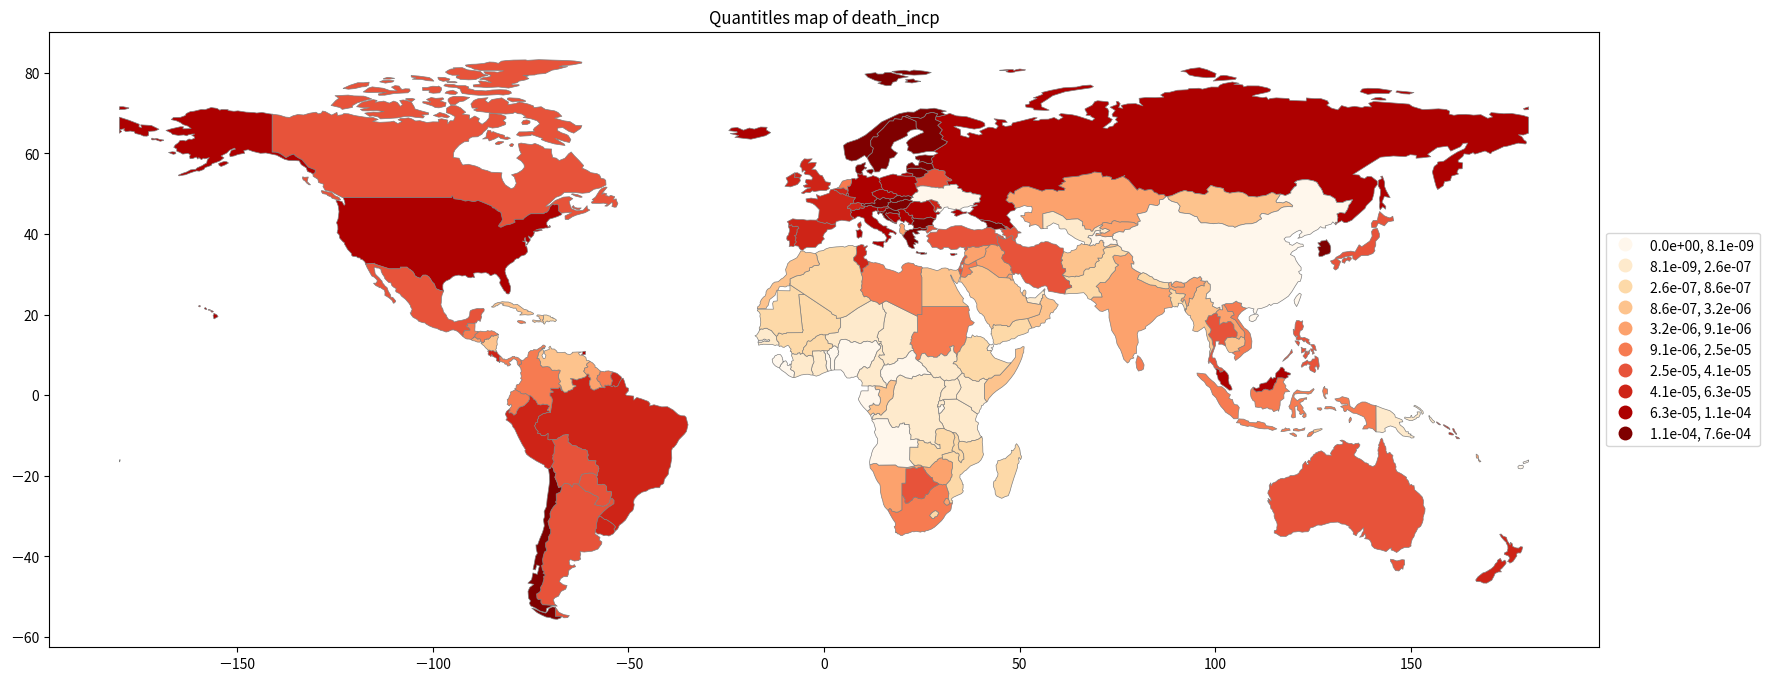

In [14]:
variable='death_incp'
# world_data.plot(column=variable,figsize=(20, 10),scheme='QUANTILES', k=10, edgecolor='gray', linewidth=0.5,
#             cmap='OrRd', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"},
#             missing_kwds={'color': 'lightgrey', "edgecolor": "gray", "hatch": "///","label": "Missing values"})
world_data.plot(column=variable,figsize=(20, 10),scheme='QUANTILES', k=10, edgecolor='gray', linewidth=0.5,
            cmap='OrRd', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})

plt.savefig(pth+'death_incp_202203.png',dpi=300)
plt.title("Quantitles map of " + variable)
plt.show()

# 鄰近矩陣
* 基本的鄰近定義，有如下幾個：
 * 1 queen 週圍邊界有接壤者
 * 2 rook 東西南北有接壤者
 * 3 knn 最接近的 n 個
 * 4 kernel 常態分佈決定鄰居及權數
 * 5 DistanceBand 一定距離以內是為鄰居


In [15]:
def check_w(w):
    # 無鄰居者的 id
    island=w.islands
    x=[];y=[]
    for n in range(len(w.histogram)):
        x.append(w.histogram[n][0])
        y.append(w.histogram[n][1])
    plt.figure(figsize=(10,6))
    plt.bar(x,y)
    print ("num. of observations:",w.n)
    print ("num. of islands:",island)
    print (list(world_data.iloc[island].Country))
    print ("histogram of w")


## queen

In [16]:
# queen 鄰近矩陣
w_queen =  lps.weights.Queen.from_dataframe(world_data)
# 列標準化
w_queen.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 122, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 125, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 152, ' is an island (no neighbors)')


num. of observations: 154
num. of islands: [0, 39, 40, 68, 78, 84, 120, 121, 122, 123, 125, 129, 132, 138, 142, 152]
['Fiji', 'Jamaica', 'Cuba', 'Madagascar', 'Vanuatu', 'South Korea', 'Solomon Islands', 'New Zealand', 'Australia', 'Sri Lanka', 'Taiwan', 'Iceland', 'Philippines', 'Japan', 'Cyprus', 'Trinidad and Tobago']
histogram of w


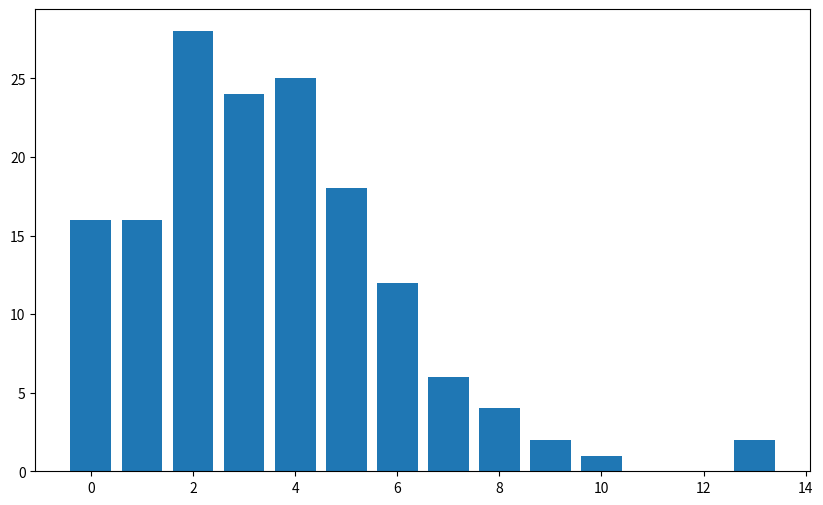

In [17]:
check_w(w_queen)

## rook

In [18]:
w_rook =  lps.weights.Rook.from_dataframe(world_data)
# 列標準化
w_rook.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 122, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 125, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 152, ' is an island (no neighbors)')


num. of observations: 154
num. of islands: [0, 39, 40, 68, 78, 84, 120, 121, 122, 123, 125, 129, 132, 138, 142, 152]
['Fiji', 'Jamaica', 'Cuba', 'Madagascar', 'Vanuatu', 'South Korea', 'Solomon Islands', 'New Zealand', 'Australia', 'Sri Lanka', 'Taiwan', 'Iceland', 'Philippines', 'Japan', 'Cyprus', 'Trinidad and Tobago']
histogram of w


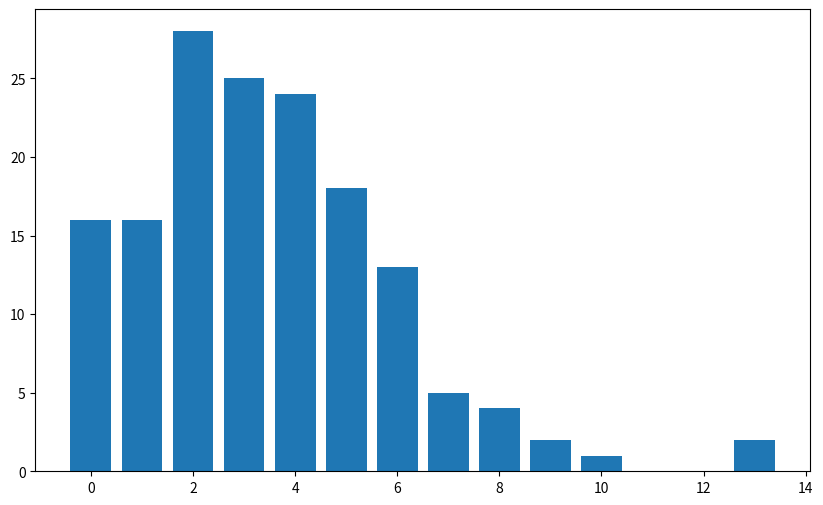

In [19]:
check_w(w_rook)

## Knn

In [20]:
# wnn5 鄰近矩陣
w_knn10 =  lps.weights.KNN.from_dataframe(world_data,k=10)
# 列標準化
w_knn10.transform = 'r'

num. of observations: 154
num. of islands: []
[]
histogram of w


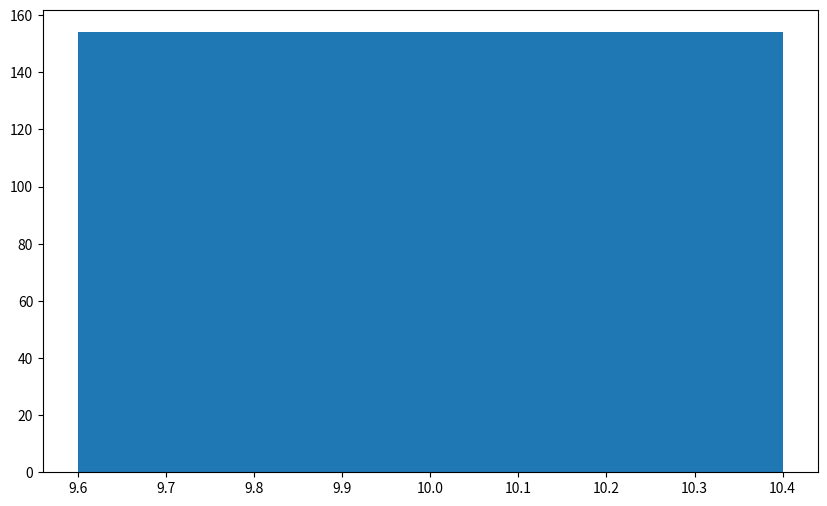

In [21]:
check_w(w_knn10)

## Kernel 鄰近矩陣

In [22]:
# Kernel 鄰近矩陣
w_kernel =  lps.weights.Kernel.from_dataframe(world_data,bandwidth=10)
# 列標準化
w_kernel.transform = 'r'

num. of observations: 154
num. of islands: []
[]
histogram of w


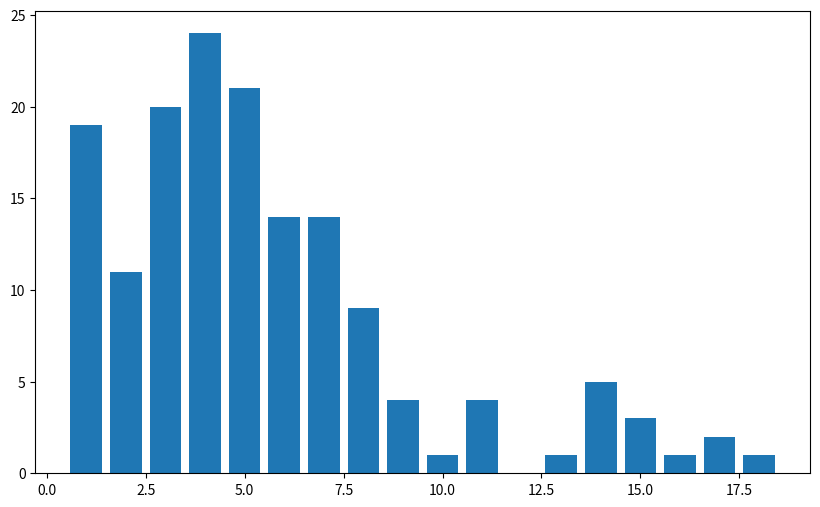

In [23]:
check_w(w_kernel)

## DistanceBand 鄰近矩陣

In [24]:
# DistanceBand 鄰近矩陣
w_dis =  lps.weights.DistanceBand.from_dataframe(world_data,threshold=10,binary=False,alpha=-2.)
# 列標準化
w_dis.transform = 'r'

('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 85, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 122, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 124, ' is an island (no neighbors)')
('WARNING: ', 125, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')


num. of observations: 154
num. of islands: [2, 3, 6, 17, 19, 22, 24, 68, 84, 85, 121, 122, 123, 124, 125, 129, 132, 138, 145]
['Canada', 'United States', 'Papua New Guinea', 'Russia', 'Timor-Leste', 'Mexico', 'Brazil', 'Madagascar', 'South Korea', 'Mongolia', 'New Zealand', 'Australia', 'Sri Lanka', 'China', 'Taiwan', 'Iceland', 'Philippines', 'Japan', 'Libya']
histogram of w


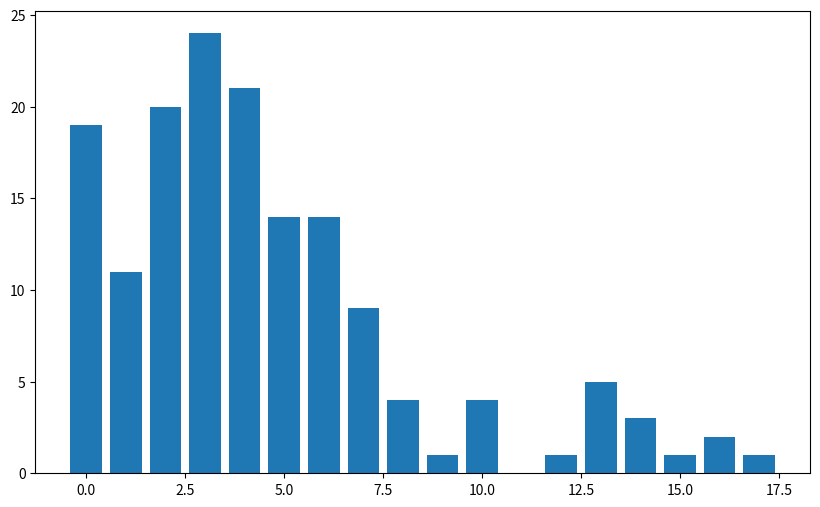

In [25]:
check_w(w_dis)

## neighbors and weights

In [26]:
len(w_kernel.neighbors)

154

In [27]:
w_kernel.neighbors[0]

[120, 0, 78]

In [28]:
np.sum(w_kernel.weights[0])

1.0

### print weights

In [29]:
# print weights
weights=w_queen.weights
for n in range(len(weights)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in weights[n]:
     print (round(m,2),end=',')


 0 :
    
 1 :
    0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,
 2 :
    1.0,
 3 :
    0.5,0.5,
 4 :
    0.25,0.25,0.25,0.25,
 5 :
    0.25,0.25,0.25,0.25,
 6 :
    1.0,
 7 :
    0.33,0.33,0.33,
 8 :
    0.2,0.2,0.2,0.2,0.2,
 9 :
    0.33,0.33,0.33,
 10 :
    0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,
 11 :
    0.5,0.5,
 12 :
    0.2,0.2,0.2,0.2,0.2,
 13 :
    0.17,0.17,0.17,0.17,0.17,0.17,
 14 :
    0.2,0.2,0.2,0.2,0.2,
 15 :
    1.0,
 16 :
    1.0,
 17 :
    0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,
 18 :
    0.33,0.33,0.33,
 19 :
    1.0,
 20 :
    0.17,0.17,0.17,0.17,0.17,0.17,
 21 :
    1.0,
 22 :
    0.5,0.5,
 23 :
    0.5,0.5,
 24 :
    0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,
 25 :
    0.2,0.2,0.2,0.2,0.2,
 26 :
    0.2,0.2,0.2,0.2,0.2,
 27 :
    0.2,0.2,0.2,0.2,0.2,
 28 :
    0.5,0.5,
 29 :
    0.5,0.5,
 30 :
    0.5,0.5,
 31 :
    0.33,0.33,0.33,
 32 :
    0.5,0.5,
 33 :
    0.33,0.33,0.33,
 34 :
    0.33,0.33,0.33,
 35 :
    0.33,0.33,0.33,
 36 :
    

### print neighbors

In [30]:
# print neighbors
neighbors=w_queen.neighbors
for n in range(len(neighbors)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in neighbors[n]:
     print (m,end=',')


 0 :
    
 1 :
    65,10,12,148,149,60,61,62,
 2 :
    3,
 3 :
    2,22,
 4 :
    17,93,124,5,
 5 :
    91,4,93,92,
 6 :
    7,
 7 :
    19,133,6,
 8 :
    23,24,25,139,9,
 9 :
    8,25,26,
 10 :
    64,65,1,148,149,153,58,60,57,
 11 :
    146,12,
 12 :
    1,146,148,153,11,
 13 :
    144,145,146,153,14,57,
 14 :
    48,145,50,57,13,
 15 :
    16,
 16 :
    15,
 17 :
    97,130,131,4,98,99,135,104,105,106,18,85,124,
 18 :
    96,17,135,
 19 :
    7,
 20 :
    21,41,42,43,62,63,
 21 :
    20,
 22 :
    33,3,
 23 :
    8,24,
 24 :
    34,35,36,37,8,139,23,25,26,27,
 25 :
    8,9,26,139,24,
 26 :
    38,24,9,27,25,
 27 :
    34,38,24,26,28,
 28 :
    27,29,
 29 :
    28,30,
 30 :
    29,31,
 31 :
    32,33,30,
 32 :
    33,31,
 33 :
    32,22,31,
 34 :
    24,27,35,
 35 :
    24,34,36,
 36 :
    24,35,37,
 37 :
    36,107,113,114,115,118,24,126,
 38 :
    26,27,
 39 :
    
 40 :
    
 41 :
    62,42,20,60,
 42 :
    41,43,20,60,
 43 :
    64,42,20,60,
 44 :
    45,69,46,
 45 :
    48,53,

In [31]:
# index 轉換為國名
data=zip(world_data.index, world_data.Country) #創建了一個 zip 物件，將 world_data 資料框的索引值和 Country 欄位進行配對。
dic_country=dict(data) #將 zip 物件轉換為字典 dic_country，這個字典將資料框的索引值映射到相應的國家名稱。
for n in range(len(world_data)):
   print ("\n",dic_country[n],":")
   print ('    ',end='')
   for m in neighbors[n]:
     if n != m:
         print (dic_country[m],end=',')


 Fiji :
    
 Tanzania :
    Burundi,Democratic Republic of the Congo,Kenya,Uganda,Rwanda,Zambia,Malawi,Mozambique,
 Canada :
    United States,
 United States :
    Canada,Mexico,
 Kazakhstan :
    Russia,Kyrgyzstan,China,Uzbekistan,
 Uzbekistan :
    Afghanistan,Kazakhstan,Kyrgyzstan,Tajikistan,
 Papua New Guinea :
    Indonesia,
 Indonesia :
    Timor-Leste,Malaysia,Papua New Guinea,
 Argentina :
    Uruguay,Brazil,Bolivia,Paraguay,Chile,
 Chile :
    Argentina,Bolivia,Peru,
 Democratic Republic of the Congo :
    Angola,Burundi,Tanzania,Uganda,Rwanda,South Sudan,Congo,Zambia,Central African Republic,
 Somalia :
    Ethiopia,Kenya,
 Kenya :
    Tanzania,Ethiopia,Uganda,South Sudan,Somalia,
 Sudan :
    Egypt,Libya,Ethiopia,South Sudan,Chad,Central African Republic,
 Chad :
    Niger,Libya,Cameroon,Central African Republic,Sudan,
 Haiti :
    Dominican Republic,
 Dominican Republic :
    Haiti,
 Russia :
    Belarus,Azerbaijan,Georgia,Kazakhstan,Ukraine,Poland,Finland,Lithuania,Latv

In [34]:
dic_country

{0: 'Fiji',
 1: 'Tanzania',
 2: 'Canada',
 3: 'United States',
 4: 'Kazakhstan',
 5: 'Uzbekistan',
 6: 'Papua New Guinea',
 7: 'Indonesia',
 8: 'Argentina',
 9: 'Chile',
 10: 'Democratic Republic of the Congo',
 11: 'Somalia',
 12: 'Kenya',
 13: 'Sudan',
 14: 'Chad',
 15: 'Haiti',
 16: 'Dominican Republic',
 17: 'Russia',
 18: 'Norway',
 19: 'Timor-Leste',
 20: 'South Africa',
 21: 'Lesotho',
 22: 'Mexico',
 23: 'Uruguay',
 24: 'Brazil',
 25: 'Bolivia',
 26: 'Peru',
 27: 'Colombia',
 28: 'Panama',
 29: 'Costa Rica',
 30: 'Nicaragua',
 31: 'Honduras',
 32: 'El Salvador',
 33: 'Guatemala',
 34: 'Venezuela',
 35: 'Guyana',
 36: 'Suriname',
 37: 'France',
 38: 'Ecuador',
 39: 'Jamaica',
 40: 'Cuba',
 41: 'Zimbabwe',
 42: 'Botswana',
 43: 'Namibia',
 44: 'Senegal',
 45: 'Mali',
 46: 'Mauritania',
 47: 'Benin',
 48: 'Niger',
 49: 'Nigeria',
 50: 'Cameroon',
 51: 'Togo',
 52: 'Ghana',
 53: 'Cote d Ivoire',
 54: 'Liberia',
 55: 'Sierra Leone',
 56: 'Burkina Faso',
 57: 'Central African Republi

## 由 weights, neighbors 產生鄰近矩陣

In [35]:
neighbors=w_kernel.neighbors
weights=w_kernel.weights
w = W(neighbors, weights)

num. of observations: 154
num. of islands: []
[]
histogram of w


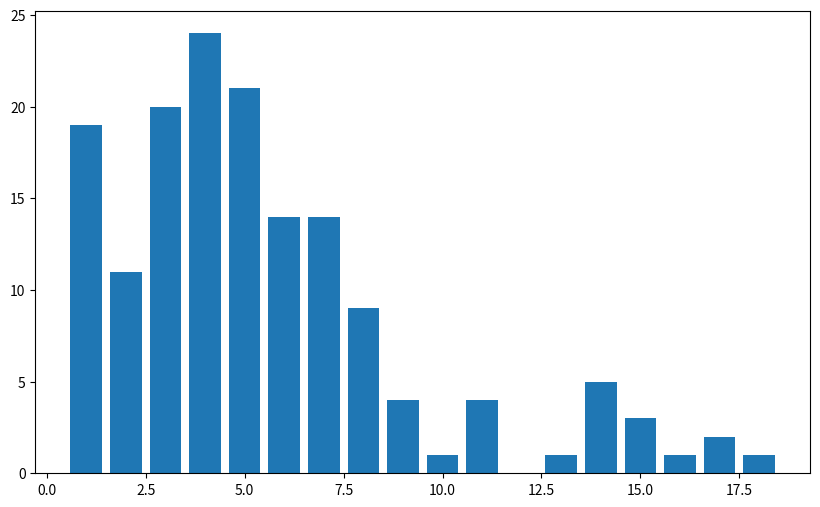

In [36]:
check_w(w)

# 鄰居依重要性加權

## w_queen 以民主的接近程度加權
* 以 w_queen 為基礎，民主接近程度加權，愈接近權數愈高。
* **民主程度相減取絕對值倒數開根號，其值愈大，相似性愈高**
* 列標準化

In [37]:
world_data.columns

Index(['continent', 'region', 'region2', 'Country', 'iso_a3', 'area', 'polyar',
       'libdem', 'partip', 'delibd', 'egalde', 'demo', 'cate', 'edu',
       'eco_dev', 'gdp_c', 'ferti', 'life', 'popu', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'E1', 'E2', 'H1', 'H2', 'H3', 'H6', 'H7', 'H8',
       'V1', 'V2', 'V3', 'health_ind', 'econ_ind', 'resp_ind', 'strin_ind',
       'case', 'case_inc', 'death', 'death_inc', 'case_p', 'death_p',
       'case_incp', 'death_incp', 'num_of_cit', 'vocano_wit', 'citi_popu',
       'citi_rate', 'dist', 'vocano', 'vocano_w_1', 'Oceania', 'Africa',
       'North Amer', 'Asia', 'South Amer', 'Europe', 'Seven seas',
       'Antarctica', 'gov_demo', 'geometry'],
      dtype='object')

In [38]:
df=world_data[['Country','demo']]
df

,Country,demo
0,Fiji,0.3044
1,Tanzania,0.3272
2,Canada,0.7514
3,United States,0.6678
4,Kazakhstan,0.1546
...,...,...
149,Rwanda,0.1664
150,Bosnia and Herzegovina,0.3868
151,Serbia,0.2736
152,Trinidad and Tobago,0.6352


In [39]:
CountryName=df.Country

In [40]:
weights={}
for n in range(len(world_data)):
   nei=w_queen.neighbors[n]
   wei=[]
   for m in nei:
      v1=df.iloc[m].demo
      v2=df.iloc[n].demo
      # 計算政體相似度，差取倒數開根方，數值愈大相似度愈高，最高為10
      if  abs(v1-v2) >= 0.01:
          wei.append(np.sqrt(1/abs(v1-v2)))
      else:
          wei.append(np.sqrt(1/0.01))
   weights[n]=wei

In [41]:
# 由 neighbors, weights 建置鄰近矩陣
w_demo = W(w_queen.neighbors, weights)
w_demo.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 84, ' is an island (no neighbors)')
('WARNING: ', 120, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 122, ' is an island (no neighbors)')
('WARNING: ', 123, ' is an island (no neighbors)')
('WARNING: ', 125, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 142, ' is an island (no neighbors)')
('WARNING: ', 152, ' is an island (no neighbors)')


### print weights, neighbors

In [42]:
# print weights
weights=w_demo.weights
for n in range(len(weights)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in weights[n]:
     print (round(m,2),end=',')


 0 :
    
 1 :
    0.08,0.12,0.18,0.12,0.09,0.13,0.12,0.15,
 2 :
    1.0,
 3 :
    0.63,0.37,
 4 :
    0.28,0.12,0.16,0.44,
 5 :
    0.18,0.49,0.13,0.19,
 6 :
    1.0,
 7 :
    0.63,0.19,0.18,
 8 :
    0.17,0.12,0.08,0.1,0.53,
 9 :
    0.63,0.1,0.27,
 10 :
    0.1,0.06,0.07,0.18,0.07,0.05,0.08,0.2,0.2,
 11 :
    0.58,0.42,
 12 :
    0.35,0.19,0.19,0.13,0.14,
 13 :
    0.32,0.12,0.1,0.16,0.21,0.1,
 14 :
    0.09,0.21,0.26,0.16,0.29,
 15 :
    1.0,
 16 :
    1.0,
 17 :
    0.18,0.11,0.05,0.19,0.06,0.05,0.04,0.04,0.04,0.04,0.04,0.05,0.09,
 18 :
    0.6,0.07,0.32,
 19 :
    1.0,
 20 :
    0.26,0.1,0.22,0.22,0.11,0.09,
 21 :
    1.0,
 22 :
    0.69,0.31,
 23 :
    0.64,0.36,
 24 :
    0.06,0.15,0.11,0.07,0.08,0.13,0.07,0.08,0.09,0.16,
 25 :
    0.16,0.16,0.17,0.28,0.23,
 26 :
    0.2,0.19,0.33,0.16,0.12,
 27 :
    0.13,0.25,0.29,0.15,0.18,
 28 :
    0.56,0.44,
 29 :
    0.63,0.37,
 30 :
    0.29,0.71,
 31 :
    0.33,0.32,0.35,
 32 :
    0.79,0.21,
 33 :
    0.58,0.27,0.16,
 34 :
    0.31,0

In [43]:
# print neighbors
neighbors=w_demo.neighbors
for n in range(len(neighbors)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in neighbors[n]:
     print (m,end=',')


 0 :
    
 1 :
    65,10,12,148,149,60,61,62,
 2 :
    3,
 3 :
    2,22,
 4 :
    17,93,124,5,
 5 :
    91,4,93,92,
 6 :
    7,
 7 :
    19,133,6,
 8 :
    23,24,25,139,9,
 9 :
    8,25,26,
 10 :
    64,65,1,148,149,153,58,60,57,
 11 :
    146,12,
 12 :
    1,146,148,153,11,
 13 :
    144,145,146,153,14,57,
 14 :
    48,145,50,57,13,
 15 :
    16,
 16 :
    15,
 17 :
    97,130,131,4,98,99,135,104,105,106,18,85,124,
 18 :
    96,17,135,
 19 :
    7,
 20 :
    21,41,42,43,62,63,
 21 :
    20,
 22 :
    33,3,
 23 :
    8,24,
 24 :
    34,35,36,37,8,139,23,25,26,27,
 25 :
    8,9,26,139,24,
 26 :
    38,24,9,27,25,
 27 :
    34,38,24,26,28,
 28 :
    27,29,
 29 :
    28,30,
 30 :
    29,31,
 31 :
    32,33,30,
 32 :
    33,31,
 33 :
    32,22,31,
 34 :
    24,27,35,
 35 :
    24,34,36,
 36 :
    24,35,37,
 37 :
    36,107,113,114,115,118,24,126,
 38 :
    26,27,
 39 :
    
 40 :
    
 41 :
    62,42,20,60,
 42 :
    41,43,20,60,
 43 :
    64,42,20,60,
 44 :
    45,69,46,
 45 :
    48,53,

## 貿易網絡 ***
* 以w_knn10為基準，以國與國間貿易量加權
* 製作 neighbors, weights
* 製作鄰近矩陣，列標準化

In [44]:
# 讀檔有點久，因為檔案很大
import pandas as pd
# 讀取 WTO 各國貿易資料
fname="data/WtoData_20220401053504.xlsx"
df=pd.read_excel(path+fname)
df

,Indicator Category,Indicator Code,Indicator,Reporting Economy Code,Reporting Economy ISO3A Code,Reporting Economy,Partner Economy Code,Partner Economy ISO3A Code,Partner Economy,Product/Sector Classification Code,...,Period,Frequency Code,Frequency,Unit Code,Unit,Year,Value Flag Code,Value Flag,Text Value,Value
0,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,8,ALB,Albania,4,AFG,Afghanistan,MT2,...,Annual,A,Annual,USD,US$,2015,NaN,NaN,NaN,4973.557320
1,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,8,ALB,Albania,4,AFG,Afghanistan,MT2,...,Annual,A,Annual,USD,US$,2016,NaN,NaN,NaN,555.675171
2,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,8,ALB,Albania,4,AFG,Afghanistan,MT2,...,Annual,A,Annual,USD,US$,2017,NaN,NaN,NaN,239.071228
3,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,8,ALB,Albania,4,AFG,Afghanistan,MT2,...,Annual,A,Annual,USD,US$,2015,NaN,NaN,NaN,1241.216494
4,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,8,ALB,Albania,4,AFG,Afghanistan,MT2,...,Annual,A,Annual,USD,US$,2015,NaN,NaN,NaN,5.416747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632251,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,918,EEC,European Union,894,ZMB,Zambia,MT2,...,Annual,A,Annual,USD,US$,2019,NaN,NaN,NaN,617331.037664
632252,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,918,EEC,European Union,894,ZMB,Zambia,MT2,...,Annual,A,Annual,USD,US$,2015,NaN,NaN,NaN,194435.400612
632253,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,918,EEC,European Union,894,ZMB,Zambia,MT2,...,Annual,A,Annual,USD,US$,2016,NaN,NaN,NaN,228817.435953
632254,Bilateral imports,HS_M_0020,Bilateral imports by MTN product category,918,EEC,European Union,894,ZMB,Zambia,MT2,...,Annual,A,Annual,USD,US$,2017,NaN,NaN,NaN,171198.378976


In [45]:
df.columns

Index(['Indicator Category', 'Indicator Code', 'Indicator',
       'Reporting Economy Code', 'Reporting Economy ISO3A Code',
       'Reporting Economy', 'Partner Economy Code',
       'Partner Economy ISO3A Code', 'Partner Economy',
       'Product/Sector Classification Code', 'Product/Sector Classification',
       'Product/Sector Code', 'Product/Sector', 'Period Code', 'Period',
       'Frequency Code', 'Frequency', 'Unit Code', 'Unit', 'Year',
       'Value Flag Code', 'Value Flag', 'Text Value', 'Value'],
      dtype='object')

In [46]:
df=df[['Reporting Economy ISO3A Code','Reporting Economy','Partner Economy ISO3A Code','Partner Economy','Year','Value']]
df.iloc[:30]

,Reporting Economy ISO3A Code,Reporting Economy,Partner Economy ISO3A Code,Partner Economy,Year,Value
0,ALB,Albania,AFG,Afghanistan,2015,4.973557e+03
1,ALB,Albania,AFG,Afghanistan,2016,5.556752e+02
2,ALB,Albania,AFG,Afghanistan,2017,2.390712e+02
3,ALB,Albania,AFG,Afghanistan,2015,1.241216e+03
4,ALB,Albania,AFG,Afghanistan,2015,5.416747e+00
5,ALB,Albania,AFG,Afghanistan,2017,1.181333e+00
6,ALB,Albania,AFG,Afghanistan,2015,7.231395e+02
7,ALB,Albania,AFG,Afghanistan,2015,2.686330e+00
8,ALB,Albania,DZA,Algeria,2015,2.049046e+01
9,ALB,Albania,DZA,Algeria,2016,1.598313e+03


## 篩選簡化資料***
* 選擇2017年
* 加總各產業的總貿易量
* 保留國名與位代碼

In [48]:
# index 轉換為國名代碼 iso_a3
iso_a3=list(df['Reporting Economy ISO3A Code'])+list(df['Partner Economy ISO3A Code'])
economy= list(df['Reporting Economy'])+list(df['Partner Economy'])
data=zip(iso_a3, economy)
dic_country=dict(data)
iso_a3= list(dic_country.keys())
economy=list(dic_country.values())

country=[]
c_iso=[]
parter=[]
p_iso=[]
value=[]
year=2017

for n in range(len(iso_a3)):
   # 貿易伙伴名單，三位代碼
   nei=df[(df['Reporting Economy ISO3A Code']==iso_a3[n]) & (df.Year==year)]['Partner Economy ISO3A Code'].unique()
   # 鄰居逐一計算貿易總額
   for m in nei:
      # 篩選 標的國，鄰居國，年度，加總變數，注意設條件要兩兩成對
      v=df[(df['Reporting Economy ISO3A Code']==iso_a3[n]) & ((df.Year==year) & (df['Partner Economy ISO3A Code']==m))].Value.sum()
      # 該國總貿易量加入 list
      country.append(dic_country[iso_a3[n]])
      c_iso.append(iso_a3[n])
      parter.append(dic_country[m])
      p_iso.append(m)
      value.append(v)
   print (n, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,

In [49]:
data=list(zip(country, c_iso, parter, p_iso, value))
df=pd.DataFrame(data, columns=['Reporting Economy','Reporting Economy ISO3A Code','Reporting Economy','Partner Economy ISO3A Code','Value'])
df

,Reporting Economy,Reporting Economy ISO3A Code,Reporting Economy,Partner Economy ISO3A Code,Value
0,Albania,ALB,Afghanistan,AFG,2.402526e+02
1,Albania,ALB,Algeria,DZA,1.898706e+07
2,Albania,ALB,Andorra,AND,3.246021e+01
3,Albania,ALB,Antigua and Barbuda,ATG,7.966815e+04
4,Albania,ALB,Azerbaijan,AZE,5.851681e+04
...,...,...,...,...,...
11458,European Union (partner code),EEC,Samoa,WSM,6.225033e+06
11459,European Union (partner code),EEC,Yemen,YEM,3.598149e+07
11460,European Union (partner code),EEC,Serbia,SRB,1.019041e+10
11461,European Union (partner code),EEC,Montenegro,MNE,1.858849e+08


In [50]:
# xlsx 存檔
fname="data/trade_network_2017.xlsx"
df.to_excel( pth +fname)

In [51]:
##############################################################################
import pandas as pd
fname="data/trade_network_2017.xlsx"
df=pd.read_excel(path+fname)
df

,Unnamed: 0,Reporting Economy,Reporting Economy ISO3A Code,Reporting Economy.1,Partner Economy ISO3A Code,Value
0,0,Albania,ALB,Afghanistan,AFG,2.402526e+02
1,1,Albania,ALB,Algeria,DZA,1.898706e+07
2,2,Albania,ALB,Andorra,AND,3.246021e+01
3,3,Albania,ALB,Antigua and Barbuda,ATG,7.966815e+04
4,4,Albania,ALB,Azerbaijan,AZE,5.851681e+04
...,...,...,...,...,...,...
11458,11458,European Union (partner code),EEC,Samoa,WSM,6.225033e+06
11459,11459,European Union (partner code),EEC,Yemen,YEM,3.598149e+07
11460,11460,European Union (partner code),EEC,Serbia,SRB,1.019041e+10
11461,11461,European Union (partner code),EEC,Montenegro,MNE,1.858849e+08


## w_knn10 以貿易量加權 ***

In [52]:
# 複製 w_knn10 為 w_knn， 改變其權數
w_knn=w_knn10

In [54]:
# index 轉換為國名代碼 iso_a3
data=zip(world_data.index, world_data.iso_a3)
dic_iso3=dict(data)

# 以貿易量為權數 w_knn10
neighbors=w_knn.neighbors
weights={}
year=2017
c='Reporting Economy ISO3A Code'
p='Partner Economy ISO3A Code'
for n in range(len(world_data)):
   # 所有的鄰居
   neighbor=w_knn.neighbors[n]
   wei=[]
   # 鄰居逐一計算貿易總額
   for m in neighbor:
      # 篩選 標的國，鄰居，年度，加總變數
      v=df[(df[c]==dic_iso3[n]) & (df[p]==dic_iso3[m])]
      if len(v)>0:
          wei.append(float(v.Value))
      else:
          wei.append(0)

   # 如果貿易總量加總為0
   if np.sum(wei)==0:
      # 鄰居設為0,islands
      neighbors[n]=[]
      wei=[]
   print (n, end=',')
   weights[n]=wei

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,

In [55]:
# print weights
for n in range(len(weights)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in weights[n]:
     print (round(m,2),end=',')


 0 :
    7714242.57,1690799.49,4985212.92,415537602.53,399971715.53,0,25395447.64,2389166.83,50681341.18,0,
 1 :
    
 2 :
    215655334560.49,26483996258.7,225670972.62,553061307.59,295425527.43,147362293.88,81265331.3,32547730.95,97773791.01,944438795.51,
 3 :
    280912533656.0,303016941606.0,3968501499.0,2363910510.0,4493203121.0,0,3251493330.0,310315422.0,4444261717.0,910170843.0,
 4 :
    736181106.39,248347321.66,323077180.99,2064350.32,22881078.19,68068567.49,33843647.1,25933003.3,99054.99,33807.65,
 5 :
    
 6 :
    
 7 :
    8858191734.0,1847452.0,859298194.0,28327220.0,3228760343.0,9242430103.0,11891215.0,0,27080911.0,6008914167.0,
 8 :
    855560680.27,490623718.01,1087751734.96,1248659775.35,17870228090.79,158931981.66,323425202.32,232980912.08,1286.95,13506.68,
 9 :
    
 10 :
    
 11 :
    
 12 :
    
 13 :
    
 14 :
    
 15 :
    
 16 :
    36309748.44,925175.64,5665734.53,443707827.15,32147802.82,53043281.57,380466202.72,17834896.77,207815106.54,73888041.59,
 17 :

In [56]:
# print neighbors
for n in range(len(neighbors)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in neighbors[n]:
     print (m,end=',')


 0 :
    78,120,6,121,122,19,7,132,133,125,
 1 :
    
 2 :
    3,22,40,33,31,39,32,15,30,16,
 3 :
    2,22,33,32,31,40,30,39,29,15,
 4 :
    5,93,92,91,90,94,130,131,89,75,
 5 :
    
 6 :
    
 7 :
    133,19,132,79,83,80,81,125,6,122,
 8 :
    9,23,139,25,24,26,38,27,36,35,
 9 :
    
 10 :
    
 11 :
    
 12 :
    
 13 :
    
 14 :
    
 15 :
    
 16 :
    15,39,40,152,34,28,27,30,29,31,
 17 :
    
 18 :
    96,135,127,106,105,104,99,107,137,116,
 19 :
    
 20 :
    21,63,42,43,41,62,60,61,64,68,
 21 :
    
 22 :
    33,32,31,30,29,40,3,39,28,15,
 23 :
    8,139,9,25,24,26,36,35,38,27,
 24 :
    25,139,36,35,26,23,34,152,27,38,
 25 :
    139,26,24,23,8,38,35,27,36,9,
 26 :
    38,25,27,34,28,35,139,24,29,36,
 27 :
    38,34,28,29,26,152,35,39,30,15,
 28 :
    29,30,27,31,39,38,32,33,15,40,
 29 :
    30,28,31,32,33,39,27,40,38,15,
 30 :
    31,29,32,33,28,39,40,15,27,16,
 31 :
    
 32 :
    33,31,30,29,28,39,40,15,22,38,
 33 :
    
 34 :
    
 35 :
    
 36 :
    
 37 :
    
 38 :

In [57]:
# 以貿易量加權的 w_knn10 鄰近矩陣
w_trade = W(neighbors, weights)
w_trade.transform = 'r'

('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WA

### w_knn 貿易伙伴國名列表

In [58]:
# index轉換為國名
data=zip(world_data.index, world_data.Country)
dic_country=dict(data)
for n in range(len(world_data)):
   print ("\n",n,dic_country[n],":")
   neighbors=w_trade.neighbors[n]
   print ('    ',end='')
   for m in neighbors:
     print (dic_country[m],end=',')


 0 Fiji :
    Vanuatu,Solomon Islands,Papua New Guinea,New Zealand,Australia,Timor-Leste,Indonesia,Philippines,Malaysia,Taiwan,
 1 Tanzania :
    
 2 Canada :
    United States,Mexico,Cuba,Guatemala,Honduras,Jamaica,El Salvador,Haiti,Nicaragua,Dominican Republic,
 3 United States :
    Canada,Mexico,Guatemala,El Salvador,Honduras,Cuba,Nicaragua,Jamaica,Costa Rica,Haiti,
 4 Kazakhstan :
    Uzbekistan,Kyrgyzstan,Tajikistan,Afghanistan,Pakistan,Iran,Azerbaijan,Georgia,Nepal,Kuwait,
 5 Uzbekistan :
    
 6 Papua New Guinea :
    
 7 Indonesia :
    Malaysia,Timor-Leste,Philippines,Cambodia,Vietnam,Thailand,Laos,Taiwan,Papua New Guinea,Australia,
 8 Argentina :
    Chile,Uruguay,Paraguay,Bolivia,Brazil,Peru,Ecuador,Colombia,Suriname,Guyana,
 9 Chile :
    
 10 Democratic Republic of the Congo :
    
 11 Somalia :
    
 12 Kenya :
    
 13 Sudan :
    
 14 Chad :
    
 15 Haiti :
    
 16 Dominican Republic :
    Haiti,Jamaica,Cuba,Trinidad and Tobago,Venezuela,Panama,Colombia,Nicaragua,Co

## 以貿易關係作為鄰近矩陣 ***

In [59]:
# index 轉換為國名代碼 iso_a3
data=zip(world_data.index, world_data.iso_a3)
dic_iso3=dict(data)

# iso_a3 轉換為國名代碼 index
data=zip(world_data.iso_a3,world_data.index)
dic_index=dict(data)

# 以貿易量為權數
weights={}
neighbors={}
year=2017
c='Reporting Economy ISO3A Code'
p='Partner Economy ISO3A Code'
for n in range(len(world_data)):
   # 所有的鄰居 iso_o3
   nei=df[(df[c]==dic_iso3[n])][p].unique()
   # iso_03 改為 index
   nei_id=[]
   for k in nei:
      # 如果 dic_index 沒有這個國家
      try:
         nei_id.append(dic_index[k])
      except:
         pass
   neighbors[n]=nei_id
   wei=[]
   # 鄰居逐一計算貿易總額
   for m in nei_id:
      # 篩選 標的國，鄰居國，年度，加總變數，注意設條件要兩兩成對
      v=df[(df[c]==dic_iso3[n])  & (df[p]==dic_iso3[m])]
      if len(v)>0:
          wei.append(float(v.Value))
      else:
          wei.append(0)
   weights[n]=wei
   print (n, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,

### print weights, neighbors

In [60]:
# print weights
for n in range(len(weights)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in weights[n]:
     print (round(m,2),end=',')


 0 :
    366425.03,399971715.53,2465589.41,1879374.52,7398328.5,66.13,996856.75,1690799.49,192495.42,56111.23,657988.72,26629.78,19174.57,16022395.93,23920.07,3835549.41,924766.39,378626914.66,238931.85,7531.06,100349.95,235.33,85358.82,40259.98,6276167.05,11183.06,4178.09,2011.49,1367410.76,15921156.68,14043.98,507373.36,8519949.27,2591.07,28761.85,122267.28,1946.34,20059.97,12719.03,53330456.71,25395447.64,166107.3,320.91,837365.45,2146263.53,7145502.92,60621.89,91947093.22,2761.24,2311.49,69340.79,95618328.52,22681.19,1034.19,50932.5,7440.62,182.82,2143.74,63846.5,16713.81,158416.76,50681341.18,27562.83,1573025.85,6338.85,43293.02,77.31,79722.56,190375.99,5695.09,5438017.82,7714242.57,415537602.53,107577.61,145388.98,1360792.82,4985212.92,420.58,566.45,2389166.83,138337.33,36232.62,810206.18,980054.45,77942.02,9225.05,629.17,84293.51,20911395.17,7513.56,2318962.02,2827672.98,8138853.05,649187.66,14537325.79,74003.15,54828561.43,1235.97,4315229.64,3722.99,1533557.92,156731.52,132533

In [61]:
# print neighbors
for n in range(len(neighbors)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in neighbors[n]:
     print (m,end=',')


 0 :
    8,122,100,87,115,150,24,120,108,82,97,79,50,2,57,123,9,124,27,29,112,40,142,137,127,16,146,106,135,37,59,131,107,52,109,33,35,101,129,86,7,94,76,119,66,126,39,138,4,72,12,84,75,81,67,105,54,104,114,68,61,133,45,22,85,143,62,77,43,89,116,78,121,48,18,90,6,139,26,132,99,117,74,17,141,44,55,136,83,134,20,118,63,96,113,95,80,152,73,70,110,98,144,128,3,34,140,
 1 :
    
 2 :
    91,111,71,64,130,8,122,100,87,115,88,25,150,42,24,120,108,82,65,97,79,50,57,123,14,9,124,27,58,10,29,112,40,142,137,47,127,16,38,32,146,106,0,135,37,147,59,131,69,107,52,109,33,35,15,31,101,129,86,7,94,76,119,66,126,53,39,138,4,72,12,84,75,93,81,67,21,105,54,145,104,114,68,61,133,45,46,22,85,102,143,62,77,43,89,116,78,121,30,48,49,18,90,28,6,139,26,132,99,117,19,74,17,149,141,44,55,136,83,134,11,20,41,118,153,13,36,63,96,113,95,92,80,51,152,73,70,110,148,98,144,128,1,3,56,23,5,34,140,151,60,
 3 :
    91,111,71,64,130,8,122,100,87,115,88,25,150,42,24,120,108,82,65,97,79,50,2,57,123,14,9,124,27,58,10,29,112,

### 製作 鄰近矩陣

In [62]:
# 鄰近矩陣
w_trade2 = W(neighbors, weights)
w_trade2.transform = 'r'

('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 31, ' is an island (no neighbors)')
('WARNING: ', 33, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WA

### show country name

In [63]:
# 轉換為國名
data=zip(world_data.index, world_data.Country)
dic_country=dict(data)
for n in range(len(world_data)):
   print ("\n",n,dic_country[n],":")
   neighbors=w_trade2.neighbors[n]
   print ('    ',end='')
   for m in neighbors:
     print (dic_country[m],end=',')


 0 Fiji :
    Argentina,Australia,Austria,Bangladesh,Belgium,Bosnia and Herzegovina,Brazil,Solomon Islands,Bulgaria,Myanmar,Belarus,Cambodia,Cameroon,Canada,Central African Republic,Sri Lanka,Chile,China,Colombia,Costa Rica,Croatia,Cuba,Cyprus,Czech Republic,Denmark,Dominican Republic,Ethiopia,Estonia,Finland,France,Gabon,Georgia,Germany,Ghana,Greece,Guatemala,Guyana,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Kazakhstan,Jordan,Kenya,South Korea,Kuwait,Laos,Lebanon,Latvia,Liberia,Lithuania,Luxembourg,Madagascar,Malawi,Malaysia,Mali,Mexico,Mongolia,Morocco,Mozambique,Oman,Namibia,Nepal,Netherlands,Vanuatu,New Zealand,Niger,Norway,Pakistan,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Russia,Saudi Arabia,Senegal,Sierra Leone,Slovak Republic,Vietnam,Slovenia,South Africa,Spain,Eswatini,Sweden,Switzerland,Syria,Thailand,Trinidad and Tobago,United Arab Emirates,Tunisia,Turkey,Ukraine,Egypt,United Kingdom,United States,Venezuela,Yemen,
 1 

## 飛機航線網絡

In [64]:
# 讀取機場與國家對應資料
fname=path+'data/country_airport.csv'
df=pd.read_csv(fname)

In [65]:
# 機場與國家字典
dic_air=dict(zip(df.iata, df.iso_a3))
dic_air['CPO']

'CHL'

In [66]:
# 讀取航線資料
fname="data/routes.xlsx"
df=pd.read_excel(path+fname)
df

,airline,source_airport,destination_airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB
...,...,...,...
67658,ZL,WYA,ADL
67659,ZM,DME,FRU
67660,ZM,FRU,DME
67661,ZM,FRU,OSS


In [67]:
# 增加國家三位代鳳
df['sour_nat']=df.source_airport.map (dic_air)
df['dest_nat']=df.destination_airport.map (dic_air)
len(df)

67663

In [68]:
df.dropna()
len(df)

67663

In [69]:
df

,airline,source_airport,destination_airport,sour_nat,dest_nat
0,2B,AER,KZN,RUS,RUS
1,2B,ASF,KZN,RUS,RUS
2,2B,ASF,MRV,RUS,RUS
3,2B,CEK,KZN,RUS,RUS
4,2B,CEK,OVB,RUS,RUS
...,...,...,...,...,...
67658,ZL,WYA,ADL,AUS,AUS
67659,ZM,DME,FRU,RUS,KGZ
67660,ZM,FRU,DME,KGZ,RUS
67661,ZM,FRU,OSS,KGZ,KGZ


In [70]:
# index 轉換為國名代碼 iso_a3
data=zip(world_data.index, world_data.iso_a3)
dic_iso3=dict(data)

# iso_a3 轉換為國名代碼 index
data=zip(world_data.iso_a3,world_data.index)
dic_index=dict(data)

# 航線作為鄰居，權數均一
weights={}
neighbors={}
# 世界地圖，依序建立國家的neighbors, weights
for n in range(len(world_data)):
   # 該國所有的鄰居 iso_o3
   nei=df[(df['sour_nat']==dic_iso3[n])]['dest_nat'].unique()
   # 鄰居與權數
   nei_id=[]
   wei=[]
   #　從nei篩選鄰居，取 iso_a3
   for k in nei:
      # 如果 dic_index 有這個國家
      try:
         # 自己和自己不是鄰居
         if k!= dic_iso3[n]:
             nei_id.append(dic_index[k])
             wei.append(float(1))
      # 如果 dic_index 沒有這個國家
      except:
         pass
   neighbors[n]=nei_id
   weights[n]=wei
   print (n, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,

In [71]:
# 鄰近矩陣
w_airline = W(neighbors, weights)
w_airline.transform = 'r'

('WARNING: ', 74, ' is an island (no neighbors)')
('WARNING: ', 95, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')


In [72]:
# print neighbors
neighbors=w_airline.neighbors
for n in range(len(neighbors)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in neighbors[n]:
     print (m,end=',')


 0 :
    3,121,122,120,84,6,
 1 :
    116,73,146,61,12,144,41,148,20,110,62,149,77,
 2 :
    124,115,3,72,128,138,107,16,40,37,22,39,15,113,121,84,122,73,118,27,127,119,126,24,110,26,29,9,66,100,99,71,143,32,35,152,28,116,146,129,144,90,132,117,17,141,109,
 3 :
    8,16,22,34,115,109,128,118,138,37,119,126,107,24,29,39,2,122,27,33,84,26,28,32,9,15,73,72,38,135,113,0,124,139,25,30,152,31,116,117,66,86,143,20,35,49,17,52,44,96,127,18,146,129,121,105,75,99,144,100,90,132,98,141,110,
 4 :
    92,17,97,128,124,130,131,73,5,80,86,93,84,110,98,133,83,116,107,100,137,94,
 5 :
    17,105,124,4,86,80,37,73,126,107,93,130,84,110,98,133,128,138,137,66,91,94,
 6 :
    122,132,120,0,138,133,
 7 :
    132,133,73,124,122,80,138,84,141,123,144,83,
 8 :
    3,16,23,9,37,22,139,24,118,27,126,26,25,128,28,40,116,38,107,
 9 :
    3,26,8,2,37,22,27,28,25,24,118,121,139,38,16,122,
 10 :
    115,50,37,58,20,60,59,12,110,149,
 11 :
    12,148,
 12 :
    11,153,86,128,115,37,41,149,61,60,116,73,80,124,107,146,

In [73]:
# print weights
weights=w_airline.weights
for n in range(len(weights)):
   print ("\n",n,":")
   print ('    ',end='')
   for m in weights[n]:
     print (m,end=',')


 0 :
    0.16666666666666666,0.16666666666666666,0.16666666666666666,0.16666666666666666,0.16666666666666666,0.16666666666666666,
 1 :
    0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,0.07692307692307693,
 2 :
    0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659574468085,0.02127659

In [74]:
# 轉換為國名
data=zip(world_data.index, world_data.Country)
dic_country=dict(data)
for n in range(len(world_data)):
   print ("\n",n,dic_country[n],":")
   neighbors=w_airline.neighbors[n]
   print ('    ',end='')
   for m in neighbors:
     print (dic_country[m],end=',')


 0 Fiji :
    United States,New Zealand,Australia,Solomon Islands,South Korea,Papua New Guinea,
 1 Tanzania :
    Netherlands,United Arab Emirates,Ethiopia,Malawi,Kenya,Egypt,Zimbabwe,Uganda,South Africa,Turkey,Mozambique,Rwanda,Oman,
 2 Canada :
    China,Belgium,United States,Jordan,United Kingdom,Japan,Germany,Dominican Republic,Cuba,France,Mexico,Jamaica,Haiti,Switzerland,New Zealand,South Korea,Australia,United Arab Emirates,Spain,Colombia,Denmark,Ireland,Italy,Brazil,Turkey,Peru,Costa Rica,Chile,Israel,Austria,Poland,Algeria,Morocco,El Salvador,Guyana,Trinidad and Tobago,Panama,Netherlands,Ethiopia,Iceland,Egypt,Pakistan,Philippines,Portugal,Russia,Saudi Arabia,Greece,
 3 United States :
    Argentina,Dominican Republic,Mexico,Venezuela,Belgium,Greece,United Kingdom,Spain,Japan,France,Ireland,Italy,Germany,Brazil,Costa Rica,Jamaica,Canada,Australia,Colombia,Guatemala,South Korea,Peru,Panama,El Salvador,Chile,Haiti,United Arab Emirates,Jordan,Ecuador,Finland,Switzerland,Fiji,Chin

num. of observations: 154
num. of islands: [74, 95, 147]
['Qatar', 'Syria', 'Djibouti']
histogram of w


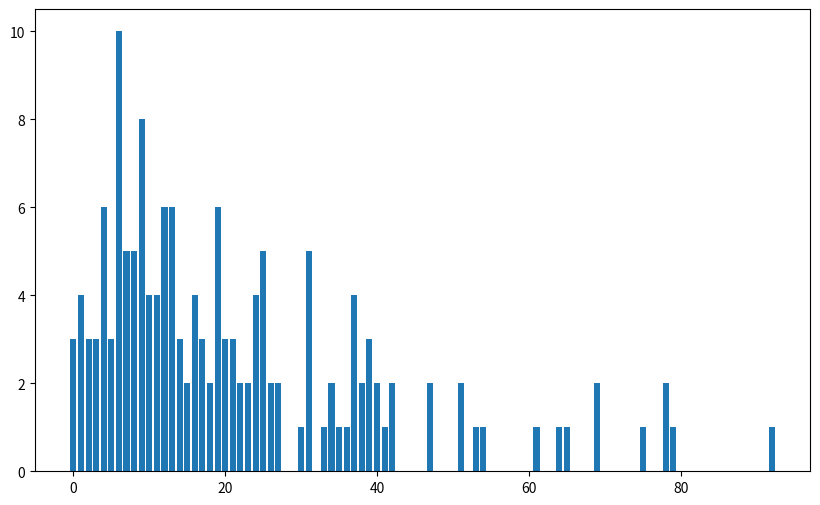

In [75]:
check_w(w_airline)

# wy 鄰居的表現
* w 為鄰質矩陣，經過列標準化
* y 為變數值
* wy 為鄰居的表現

In [76]:
# 依變數 Y
y = world_data['death_incp']

In [77]:
# WY
wy = lps.weights.lag_spatial(w_queen, y)
wy

array([0.00000000e+00, 2.71930978e-07, 9.43859223e-05, 3.05476837e-05,
       2.87446105e-05, 2.47318998e-06, 2.40189699e-05, 2.33973665e-05,
       1.87108727e-04, 4.17451174e-05, 2.84490717e-07, 2.43203198e-07,
       2.98270841e-07, 4.24119176e-06, 9.18777699e-06, 5.64590839e-07,
       1.16873095e-06, 8.72529616e-05, 1.19643775e-04, 2.40189699e-05,
       7.04740278e-06, 1.04188982e-05, 5.59476973e-05, 4.39087401e-05,
       3.03965641e-05, 1.86454348e-04, 1.74954730e-04, 2.51137838e-05,
       3.30271019e-05, 9.68142205e-06, 3.06222430e-05, 8.48200219e-06,
       1.40741503e-05, 1.77295945e-05, 2.37892569e-05, 2.06544628e-05,
       3.66481453e-05, 5.56406346e-05, 3.05913257e-05, 0.00000000e+00,
       0.00000000e+00, 1.02906486e-05, 4.86578297e-06, 1.02228427e-05,
       3.14463500e-07, 3.76229078e-07, 4.39842522e-07, 9.97400653e-08,
       2.93823097e-06, 6.77284590e-08, 2.40655464e-07, 1.51728405e-07,
       1.58023818e-07, 1.79317863e-07, 5.98343090e-08, 0.00000000e+00,
      

In [78]:
world_data['wy']=wy
world_data

,continent,region,region2,Country,iso_a3,area,polyar,libdem,partip,delibd,...,Africa,North Amer,Asia,South Amer,Europe,Seven seas,Antarctica,gov_demo,geometry,wy
0,Oceania,15.0,Oceania,Fiji,FJI,18172.866,0.418,0.279,0.197,0.308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.947915,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.000000e+00
1,Africa,8.0,Eastern Africa,Tanzania,TZA,947555.660,0.409,0.327,0.233,0.337,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.544808,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",2.719310e-07
2,North America,16.0,North America,Canada,CAN,9923995.405,0.869,0.736,0.619,0.769,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50.350102,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",9.438592e-05
3,North America,16.0,North America,United States,USA,9468306.220,0.815,0.728,0.581,0.585,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,37.470043,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",3.054768e-05
4,Asia,11.0,Central Asia,Kazakhstan,KAZ,2721207.079,0.240,0.129,0.077,0.126,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.092275,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",2.874461e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Africa,8.0,Eastern Africa,Rwanda,RWA,25305.624,0.212,0.107,0.140,0.177,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.609945,"POLYGON ((30.41910 -1.13466, 30.81613 -1.69891...",6.163870e-08
150,Europe,3.0,Southern Europe,Bosnia and Herzegovina,BIH,51537.975,0.545,0.340,0.337,0.336,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.175471,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",9.365406e-05
151,Europe,3.0,Southern Europe,Serbia,SRB,77201.660,0.342,0.239,0.234,0.258,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.879696,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",1.064240e-04
152,North America,19.0,Caribbean,Trinidad and Tobago,TTO,5041.729,0.755,0.643,0.484,0.685,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,36.691106,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0.000000e+00


In [79]:
wy=lps.weights.lag_spatial(w_trade2, y)
wy

array([4.04595633e-05, 0.00000000e+00, 7.05768189e-05, 3.92742691e-05,
       7.13687337e-05, 0.00000000e+00, 0.00000000e+00, 3.99138657e-05,
       5.66122106e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.50997962e-05, 0.00000000e+00, 8.19086424e-05, 0.00000000e+00,
       3.93514422e-05, 0.00000000e+00, 6.94090355e-05, 5.51451768e-05,
       6.80588852e-05, 6.95236278e-05, 6.83966527e-05, 6.43747288e-05,
       6.63978009e-05, 7.12331337e-05, 5.05339772e-05, 0.00000000e+00,
       5.70637351e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.55374300e-05, 0.00000000e+00,
       3.93737769e-05, 1.73842806e-05, 0.00000000e+00, 2.61653476e-05,
       3.64795060e-05, 2.47769447e-05, 7.31131681e-05, 2.73039080e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.12907317e-05,
       0.00000000e+00, 3.67827113e-05, 0.00000000e+00, 0.00000000e+00,
      

## 不同的鄰近矩陣

In [80]:
# wnn5 鄰近矩陣
w_knn10 =  lps.weights.KNN.from_dataframe(world_data,k=10)
w_knn10.transform = 'r'

In [81]:
# y=world_data.death_incp
wy_queen=lps.weights.lag_spatial(w_queen, y)
wy_rook=lps.weights.lag_spatial(w_rook, y)
wy_knn10=lps.weights.lag_spatial(w_knn10, y)
wy_kernel=lps.weights.lag_spatial(w_kernel, y)
wy_dis=lps.weights.lag_spatial(w_dis, y)
wy_demo=lps.weights.lag_spatial(w_demo, y)
wy_trade=lps.weights.lag_spatial(w_trade, y)
wy_trade2=lps.weights.lag_spatial(w_trade2, y)
wy_airline=lps.weights.lag_spatial(w_airline, y)
w_list=['wy_queen', 'wy_rook','wy_knn10',  'wy_kernel', 'wy_dis', 'wy_demo', 'wy_trade','wy_trade2','wy_airline']
data=list(zip(wy_queen, wy_rook,wy_knn10,  wy_kernel, wy_dis, wy_demo, wy_trade,wy_trade2,wy_airline))
df_wy= pd.DataFrame(data,columns=w_list)
df_wy

,wy_queen,wy_rook,wy_knn10,wy_kernel,wy_dis,wy_demo,wy_trade,wy_trade2,wy_airline
0,0.000000e+00,0.000000e+00,2.475976e-05,2.939244e-06,8.532134e-06,0.000000e+00,4.184091e-05,0.000040,0.000063
1,2.719310e-07,2.719310e-07,5.660139e-07,1.414845e-07,2.053049e-07,2.873277e-07,0.000000e+00,0.000000,0.000007
2,9.438592e-05,9.438592e-05,1.942827e-05,2.555395e-05,0.000000e+00,9.438592e-05,8.716854e-05,0.000071,0.000062
3,3.054768e-05,3.054768e-05,1.754918e-05,9.438592e-05,0.000000e+00,2.928038e-05,3.034556e-05,0.000039,0.000056
4,2.874461e-05,2.874461e-05,2.214491e-05,2.847505e-06,1.782652e-06,3.122092e-05,5.815239e-06,0.000071,0.000048
...,...,...,...,...,...,...,...,...,...
149,6.163870e-08,6.163870e-08,2.179555e-07,9.686147e-08,2.400638e-08,6.426440e-08,1.993557e-07,0.000021,0.000008
150,9.365406e-05,9.365406e-05,1.004017e-04,9.445321e-05,1.014472e-04,9.027335e-05,0.000000e+00,0.000000,0.000092
151,1.064240e-04,1.064240e-04,1.036271e-04,9.463520e-05,9.243191e-05,1.093854e-04,0.000000e+00,0.000000,0.000087
152,0.000000e+00,0.000000e+00,9.519187e-06,4.590275e-05,6.071432e-06,0.000000e+00,0.000000e+00,0.000000,0.000034


## wy 的相關矩陣

<Axes: >

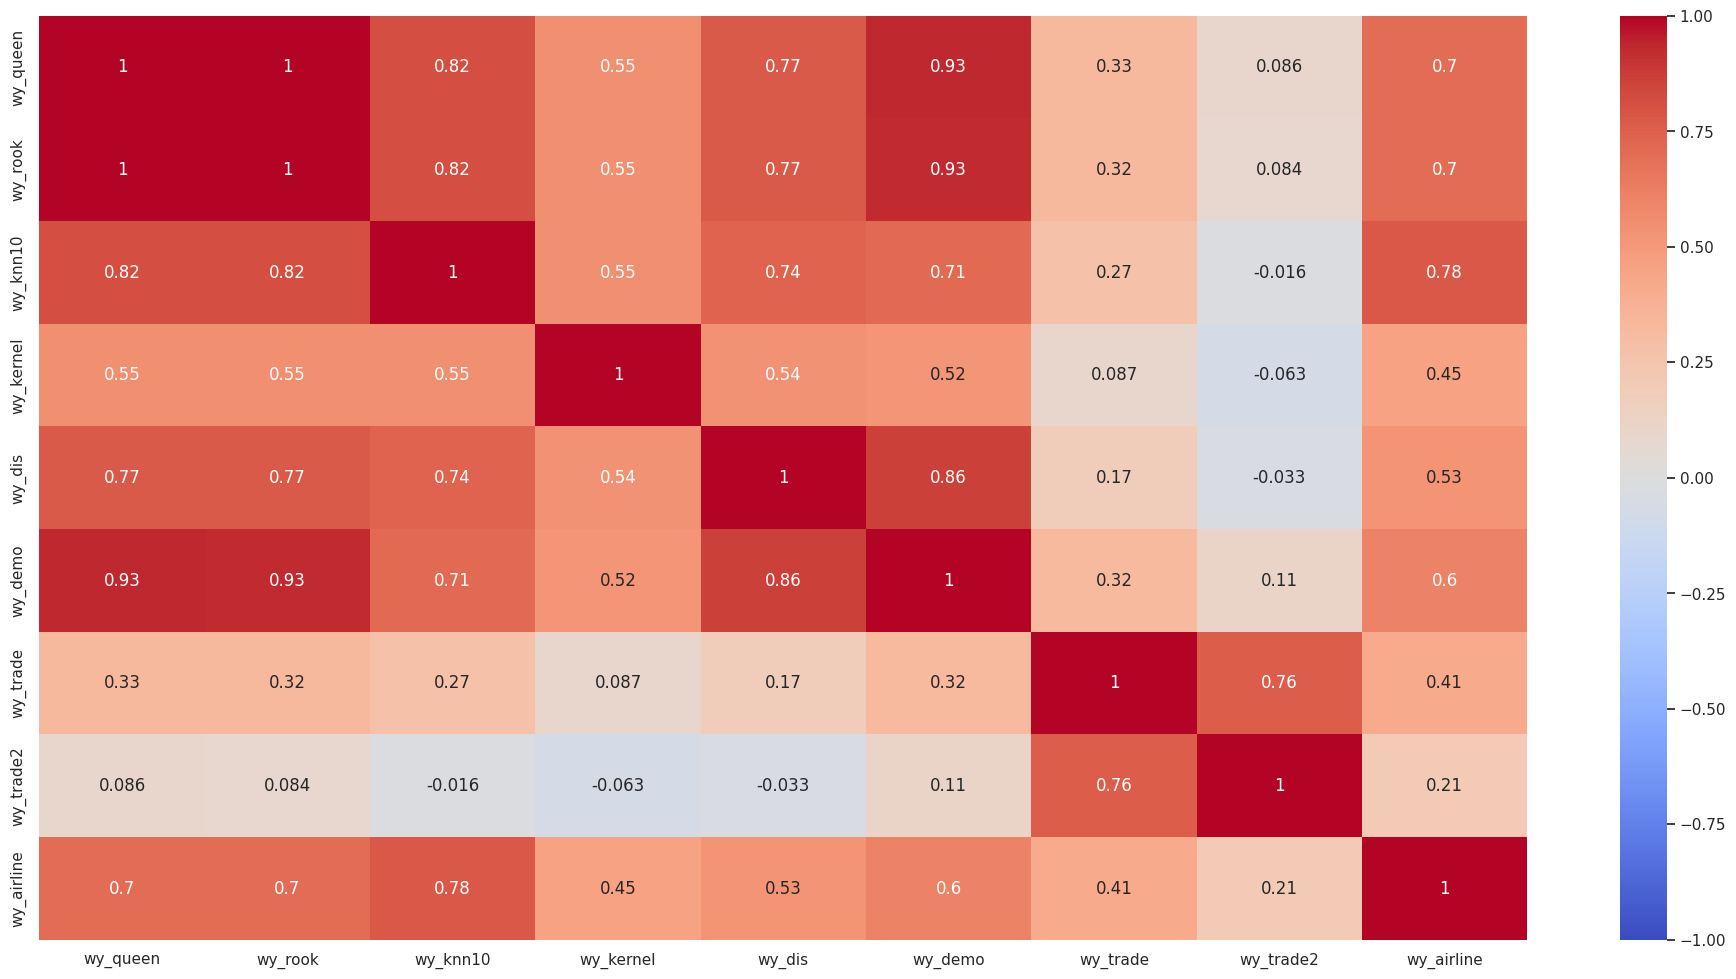

In [82]:
import seaborn as sns
sns.set(rc={'figure.figsize':(24,12)})
# 計算相關矩陣會跳過文字欄位
sns.heatmap(df_wy.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

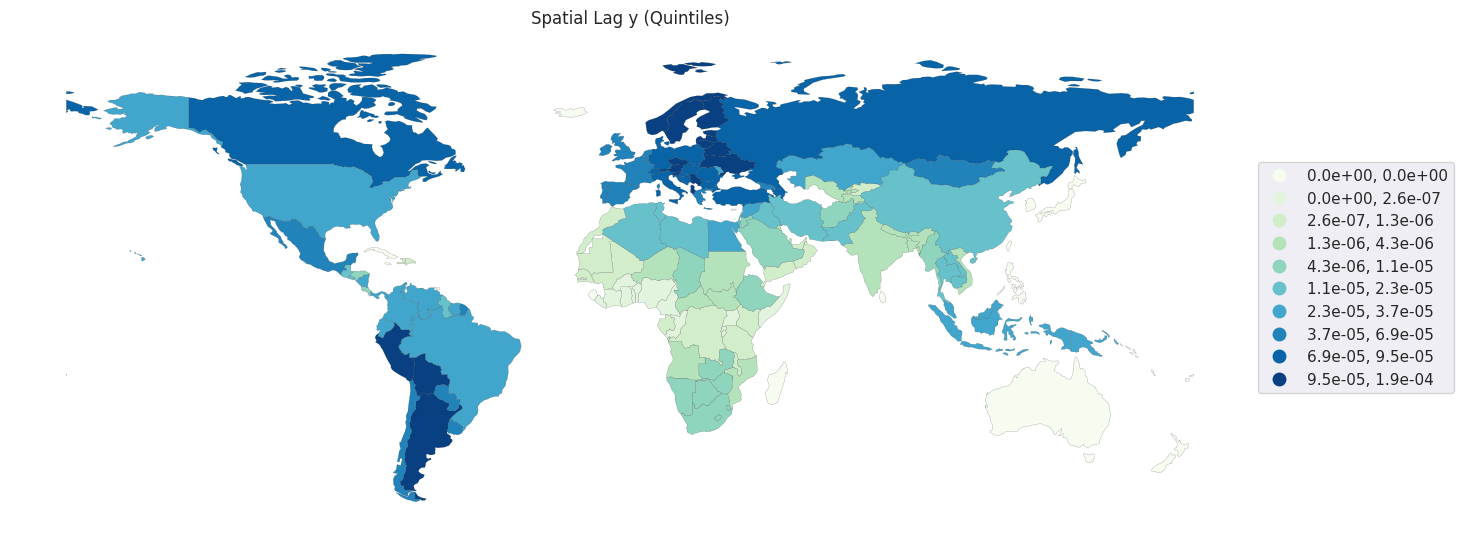

In [83]:
# 繪圖
import mapclassify as mc
f, ax = plt.subplots(1, figsize=(16, 10))
world_data.plot(column='wy', scheme='quantiles',
        k=10, cmap='GnBu', linewidth=0.1, ax=ax,
        edgecolor='k', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
# world_data.plot(column='wy', ax=ax[1], edgecolor='k',
#         scheme='quantiles', cmap='GnBu', k=10)
ax.set_axis_off()
plt.title("Spatial Lag y (Quintiles) of Death incidence of COVID-19")

plt.show()

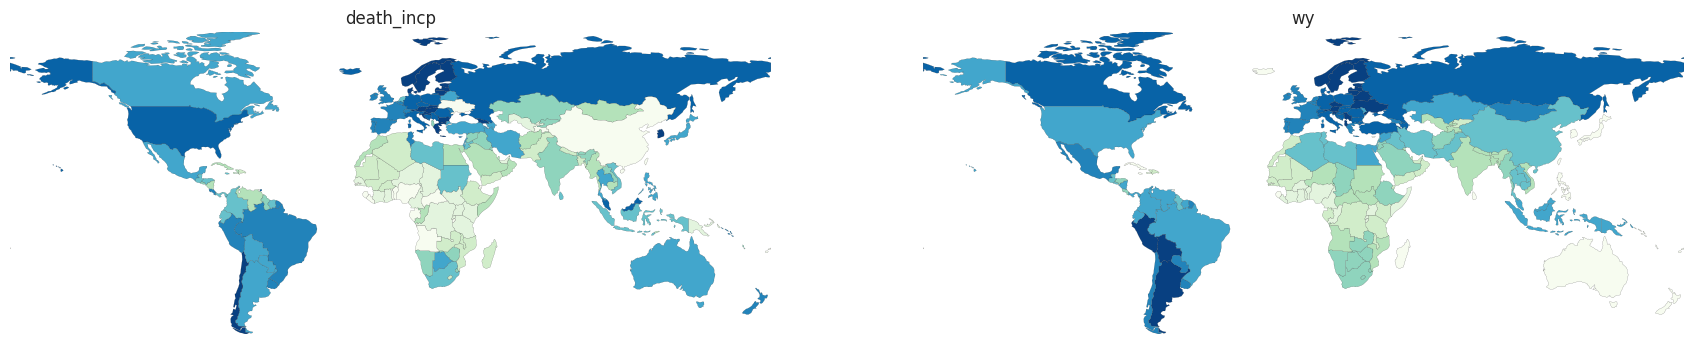

In [84]:

f,ax = plt.subplots(1,2,figsize=(2.16*10,10))
# Y
world_data.plot(column='death_incp', ax=ax[0], edgecolor='k',
        scheme="quantiles", linewidth=0.1,  k=10, cmap='GnBu')
ax[0].axis(world_data.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("death_incp")
#WY
world_data.plot(column='wy', ax=ax[1], edgecolor='k',
        scheme='quantiles',linewidth=0.1, cmap='GnBu', k=10)
ax[1].axis(world_data.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("wy")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# moran's I 檢定

In [85]:
y = np.array(world_data['death_incp'])
w=w_queen

In [86]:
from esda.moran import Moran
mi = Moran(y,  w_queen)
mi.I

0.26764044128001235

In [87]:
mi.p_sim

0.002

Text(0.5, 0, "Moran's I")

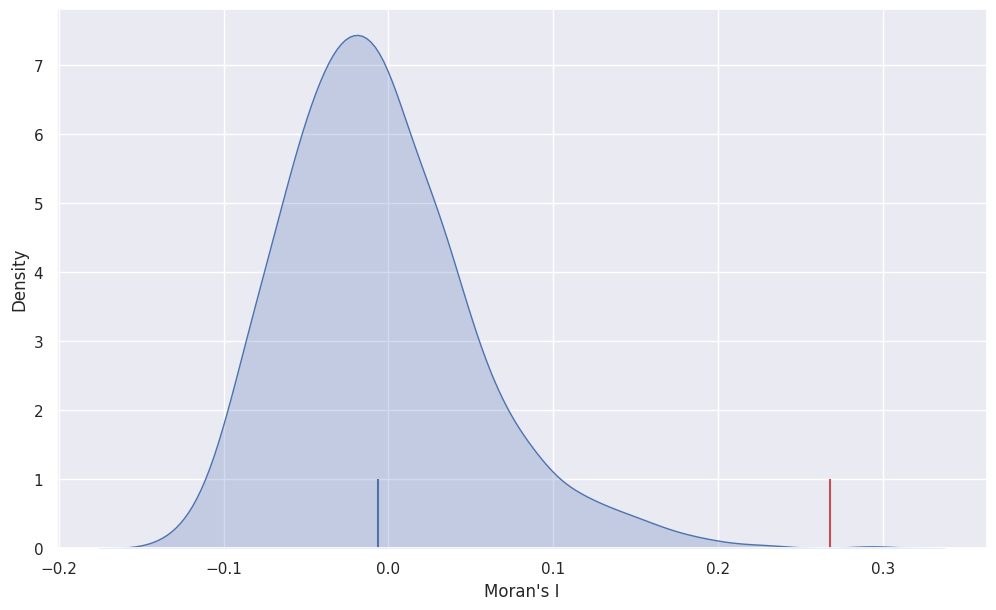

In [88]:
import seaborn as sbn
sns.set(rc={'figure.figsize':(12,7)})
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

## moran's I, p_value 比較

In [89]:
w=[w_queen,w_rook, w_kernel,w_knn10, w_dis, w_demo, w_trade,w_trade2,w_airline]
wlabel=["w_queen","w_rook", "w_kernel","w_knn5", "w_dis",'w_demo','w_trade','w_trade2','w_airline']
for n in range(len(w)):
    mi = esda.moran.Moran(y, w[n])
    print (wlabel[n], mi.I, "p=", mi.p_sim)

w_queen 0.26764044128001235 p= 0.002
w_rook 0.26742928924883275 p= 0.001
w_kernel 0.8017229588026522 p= 0.105
w_knn5 0.21292664802723252 p= 0.001
w_dis 0.28769075885935547 p= 0.001
w_demo 0.2822540468367625 p= 0.001
w_trade 0.09693630904853681 p= 0.067
w_trade2 0.010170277125955099 p= 0.259
w_airline 0.15030929267404897 p= 0.002


## moran's I 散佈圖

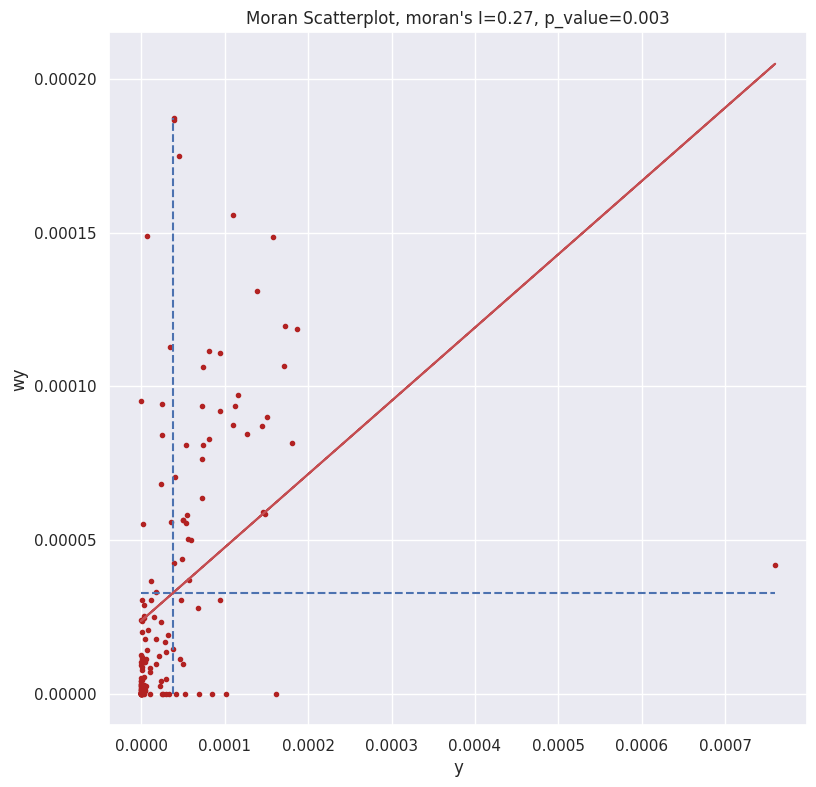

In [90]:
# moran's I 散佈圖
np.random.seed(12345)
import esda
############
w=w_queen
y=world_data['death_incp']
############
wy = lps.weights.lag_spatial(w, y)
# 係數與斜率
b, a = np.polyfit(y, wy, 1)
f, ax = plt.subplots(1, figsize=(9, 9))
# 散佈圖
plt.plot(y, wy, '.', color='firebrick')
# 縱軸
plt.vlines(y.mean(), wy.min(), wy.max(), linestyle='--')
 # 橫軸
plt.hlines(wy.mean(), y.min(), y.max(), linestyle='--')
# 趨勢線
plt.plot(y, a + b*y, 'r')
# moran's I
moran=round(esda.moran.Moran(y, w).I,2)
# p_value
p_value=round(esda.moran.Moran(y, w).p_sim, 4)
# title
plt.title("Moran Scatterplot, moran's I="+ str(moran)+', p_value='+ str(p_value))
plt.ylabel('wy')
plt.xlabel('y')
plt.show()

# local moran's I
* 有問題，待查，只有 w_knn 是正常的

In [91]:
# local moran's I
############
w=w_knn10
y=world_data['death_incp']
############
from esda.moran import Moran_Local
li = Moran_Local(y,w, geoda_quads=True, transformation = "r", permutations = 999)
li.q

array([2, 2, 2, 4, 2, 2, 2, 2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 2,
       2, 1, 4, 1, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 2, 4,
       2, 4, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 1, 4, 2])

## lisa_clustering

In [94]:
world_data["lisa"]=li.q

## lisa cluster 繪圖

In [95]:
(li.p_sim < 0.05).sum()

74

In [96]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [97]:
spots = ['n.sig.', 'HH']
labels = [spots[i] for i in hotspot*1]

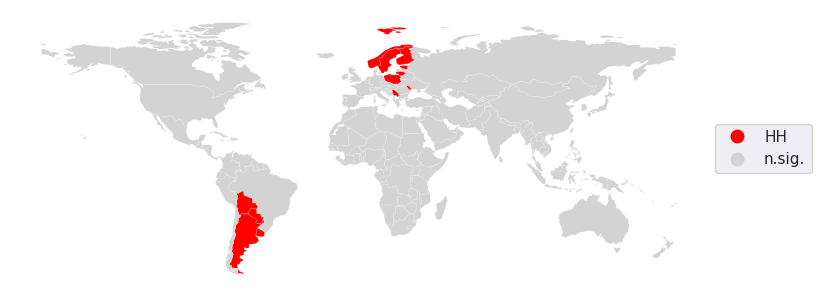

In [98]:
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
world_data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
ax.set_axis_off()
plt.show()

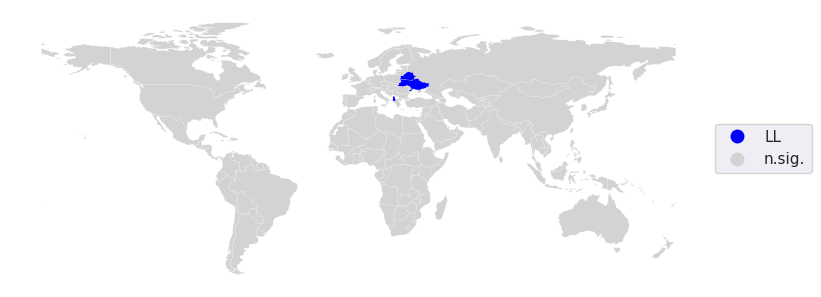

In [99]:
spots = ['n.sig.', 'LL']
labels = [spots[i] for i in coldspot*1]

from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
world_data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True,legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
ax.set_axis_off()
plt.show()

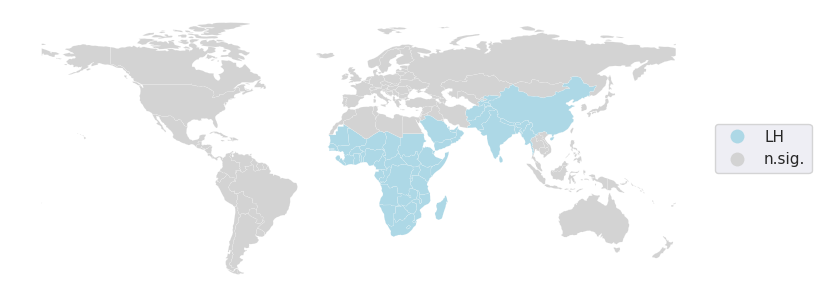

In [100]:
spots = ['n.sig.', 'LH']
labels = [spots[i] for i in doughnut*1]

from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
world_data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
ax.set_axis_off()
plt.show()

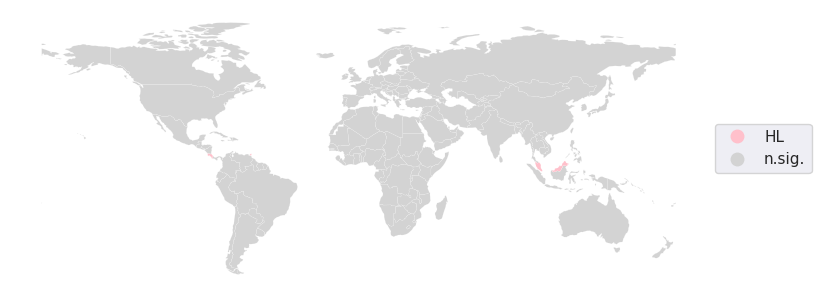

In [101]:
spots = ['n.sig.', 'HL']
labels = [spots[i] for i in diamond*1]

from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
world_data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
ax.set_axis_off()
plt.show()

In [102]:
sig = 1 * (li.p_sim < 0.05)
HH = 1 * (sig * li.q==1)
LL = 3 * (sig * li.q==3)
LH = 2 * (sig * li.q==2)
HL = 4 * (sig * li.q==4)
spots = HH + LL + LH + HL

spot_labels = [ '0 ns', '1 HH', '2 LH', '3 LL', '4 HL']
labels = [spot_labels[i] for i in spots]
labels

['0 ns',
 '2 LH',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '1 HH',
 '0 ns',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '0 ns',
 '0 ns',
 '0 ns',
 '1 HH',
 '0 ns',
 '2 LH',
 '2 LH',
 '0 ns',
 '1 HH',
 '0 ns',
 '1 HH',
 '0 ns',
 '0 ns',
 '0 ns',
 '4 HL',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '0 ns',
 '0 ns',
 '2 LH',
 '2 LH',
 '0 ns',
 '0 ns',
 '0 ns',
 '2 LH',
 '2 LH',
 '0 ns',
 '0 ns',
 '2 LH',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 '2 LH',
 '0 ns',
 '0 ns',
 '0 ns',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '2 LH',
 '0 ns',
 '0 ns',
 '1 HH',
 '3 LL',
 '3 LL',
 '1 HH',
 '0 ns',
 '0 ns',
 '1 HH',
 '0 ns',
 '1 HH',
 '0 ns',
 '1 HH',
 '0 ns',
 '0 ns',
 '0 ns',
 '0 ns',
 

In [103]:
sig = 1 * (sig )
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 2,
       0, 1, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 1, 3, 3, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 4, 2])

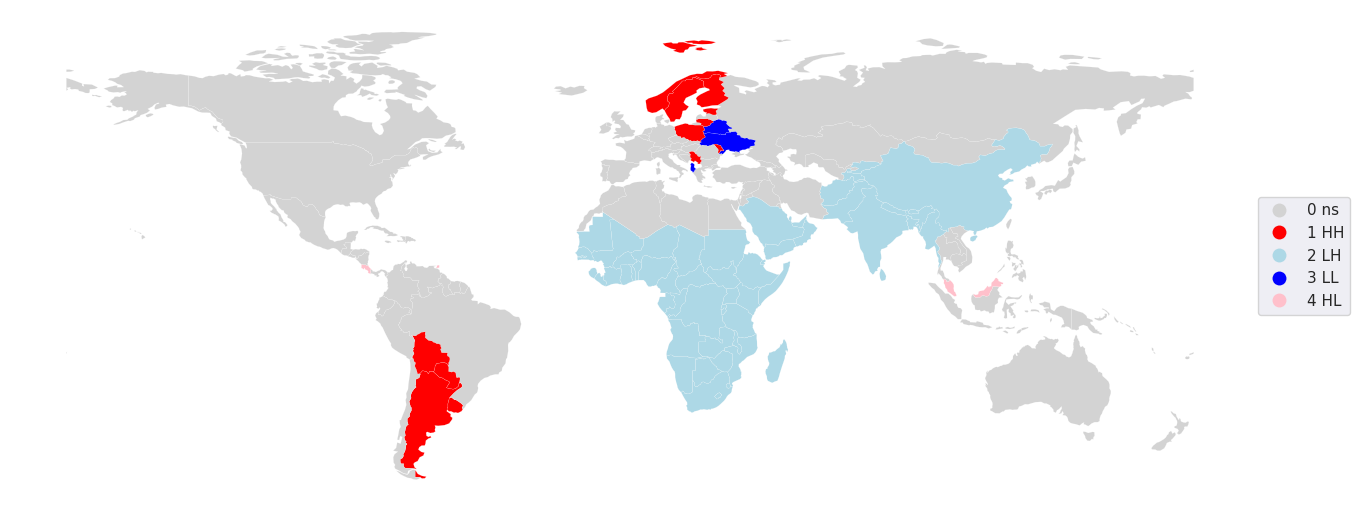

In [104]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(16,8))
world_data.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), 'fmt':"{:.1e}"})
ax.set_axis_off()
plt.show()

In [106]:
country_name=list(world_data.Country)
HH=[]
LL=[]
HL=[]
LH=[]
for n in range(len(spots)):
    if spots[n]==1:
        HH.append(country_name[n])
    elif spots[n]==2:
        LH.append(country_name[n])
    elif spots[n]==3:
        LL.append(country_name[n])
    elif spots[n]==4:
        HL.append(country_name[n])
print ('HH',HH)
print ('LH',LH)
print ('LL',LL)
print ('HL',HL)

HH ['Argentina', 'Norway', 'Uruguay', 'Bolivia', 'Sweden', 'Poland', 'Moldova', 'Lithuania', 'Estonia', 'Finland', 'Paraguay', 'Serbia']
LH ['Tanzania', 'Democratic Republic of the Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'South Africa', 'Lesotho', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon', 'Togo', 'Ghana', 'Cote d Ivoire', 'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Republic', 'Congo', 'Gabon', 'Zambia', 'Malawi', 'Mozambique', 'Eswatini', 'Angola', 'Burundi', 'Madagascar', 'Gambia', 'United Arab Emirates', 'Qatar', 'Oman', 'Myanmar', 'India', 'Bangladesh', 'Bhutan', 'Nepal', 'Pakistan', 'Afghanistan', 'Tajikistan', 'Kyrgyzstan', 'Sri Lanka', 'China', 'Yemen', 'Saudi Arabia', 'Ethiopia', 'Djibouti', 'Uganda', 'Rwanda', 'South Sudan']
LL ['Belarus', 'Ukraine', 'Albania']
HL ['Costa Rica', 'Malaysia', 'Trinidad and Tobago']
